In [1]:
library(tidyverse)
library(data.table)
library(ggridges)
library(wesanderson)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
# custom theme for plots
ng1 <- theme(aspect.ratio=0.7,panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border=element_blank(),
        axis.line.x = element_line(color="black",size=1),
        axis.line.y = element_line(color="black",size=1),
        axis.ticks=element_line(size = 1, color="black"),
        axis.ticks.length=unit(0.25, 'cm'),
        axis.text=element_text(color="black",size=15),
        axis.title=element_text(color="black",size=1),
        axis.title.y=element_text(vjust=2,size=17),
        axis.title.x=element_text(vjust=0.1,size=17),
        axis.text.x=element_text(size=15),
        axis.text.y=element_text(size=15),
        strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
        strip.background = element_rect(colour="black"),
        legend.position = "top", legend.direction="vertical", 
        legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
        legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

In [62]:
# Function to load genotype likelihoods
load_gls <- function(inpath){
    
    to_remove <- suppressMessages(
        read_table('../../../results/program_resources/highErrorRate_toRemove.txt', 
                   col_names = FALSE)) %>% 
        pull()
    df <- suppressMessages(read_delim(inpath, delim = '\t')) %>% 
        dplyr::select(sample, ends_with('norm')) %>% 
        filter(!(sample %in% to_remove)) %>% 
        left_join(habitat_info, by = 'sample')
    
    return(df)
    
    
}

hudson_fst <- function(p_u, p_r, n_u, n_r){
    
    # Numerator
    a <- (p_u - p_r)^2
    b <- (p_u * (1 - p_u)) / (n_u - 1)
    c <- (p_r * (1 - p_r)) / (n_r - 1)
    num <- a - b - c
    
    # Denominator
    d <- p_u * (1 - p_r)
    e <- p_r * (1 - p_u)
    denom <- d + e
    
    fst <- num / denom
   
    return(fst)
}

estimate_p <- function(df, by_site = TRUE){
    
    if(by_site == TRUE){
        df_out <- df %>% 
            group_by(city, site) %>% 
            summarise(num_aa = sum(l_aa_norm),
                      num_Aa = sum(l_Aa_norm),
                      num_AA = sum(l_AA_norm),
                      n = 2*n(),
                      p = (num_aa + (0.5 * num_Aa)) / sum(num_aa, num_Aa, num_AA)) %>% 
            dplyr::select(-starts_with('num_')) %>% 
            pivot_wider(names_from = site, values_from = c('n', 'p')) %>% 
            mutate(fst = hudson_fst(p_u, p_r, n_u, n_r)) %>% 
            left_join(., betaLog, by = 'city')
    }else{
        df_out <- df %>% 
            group_by(city) %>% 
            summarise(num_aa = sum(l_aa_norm),
                      num_Aa = sum(l_Aa_norm),
                      num_AA = sum(l_AA_norm),
                      p = (num_aa + (0.5 * num_Aa)) / sum(num_aa, num_Aa, num_AA)) %>% 
            dplyr::select(-starts_with('num_'))
    }
    
    return(df_out)
}

load_plant_data <- function(city){
    
    inpath <- '../../phenotypic-analyses/data/clean/individualPlant_allCities/'
    full_path <- paste0(inpath, city, '.csv')
    df <- suppressMessages(read_csv(full_path)) %>%
        dplyr::select(city, population, plant, hcn_result) %>% 
        mutate(population = as.character(population),
               plant = as.character(plant))
    if(city == 'Armidale'){
        df <- separate(df, plant, sep = '-', into = c('population', 'plant'))
    }
    
    return(df)
}

# HCN Loci Fst outlier test

- Use per-city estimates of Ac and Li deletion frequencies to estimate Hudson's Fst
- Compare Fst at HCN loci to distribution of Fst values at 4fold sites

In [4]:
habitat_info <- suppressMessages(read_delim('../../genomic-analyses/resources/glue_pc_sampleSheet.txt', delim = '\t'))
betaLog <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv'))
cyan <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_stats.csv')) %>% 
    dplyr::select(city, meanHCN)

## Correlation in mean HCN frequencies

- Correlate the city-wide HCN frequencies from the phenotyping with the estimated HCN frequencies from the genotype likelihoods at both loci. 
- Re-estimate city-wide HCN frequency from the phenotyping using only plants for which we have sequence data. 
- These should be correlated and is a good sanity check

In [5]:
# Load in genotype likelihoods for all samples at both loci
ac_gls <- load_gls('../../../results/hcn_genotyping/ac_GLs.txt')
li_gls <- load_gls('../../../results/hcn_genotyping/li_GLs.txt')

In [40]:
nrow(li_gls)

[1] 2055

In [10]:
# Create dataframe with city-wide allele frequencies and HCN frequencies
ac_freq_wholeCity <- estimate_p(ac_gls, by_site = FALSE) %>% mutate(locus = 'ac')
li_freq_wholeCity <- estimate_p(li_gls, by_site = FALSE) %>% mutate(locus = 'li')
all_freqs_wholeCity <- bind_rows(ac_freq_wholeCity, li_freq_wholeCity) %>% 
    pivot_wider(names_from = locus, values_from = p) %>% 
    mutate(hcn_est = 1 - (ac^2 + li^2 - (ac^2 * li^2)))

In [71]:
# Data frame with indivudual plant phenotype data for sequenced cities
cities <- all_freqs_wholeCity$city
df_allPlants <- map_dfr(cities, load_plant_data) %>% 
    mutate(city = case_when(city == 'Toronto' ~ 's',
                            city == 'Buenos_Aires' ~ 'Buen_Air',
                            city == 'Thessaloniki' ~ 'Thessa',
                            city == 'Christchurch' ~ 'Chrchurch',
                            TRUE ~ city)) %>% 
    mutate(sample = paste(city, population, plant, sep = '_'))

city,population,plant,hcn_result,sample
<chr>,<chr>,<chr>,<dbl>,<chr>
Albuquerque,1,1,1,Albuquerque_1_1
Albuquerque,1,2,0,Albuquerque_1_2
Albuquerque,1,3,0,Albuquerque_1_3
Albuquerque,1,4,0,Albuquerque_1_4
Albuquerque,1,5,0,Albuquerque_1_5
Albuquerque,1,6,0,Albuquerque_1_6


In [84]:
# Data frame containing only individual plants for which we have sequence data
# NOTE: There are about 100 samples with sample ID issues that are excluded here. This shouldn't affect much
hcnFreq_fromPhenotype <- df_allPlants %>% 
    group_by(city) %>% 
    summarise(total_plants = sum(!is.na(hcn_result)),
              num_hcn = sum(hcn_result, na.rm = TRUE),
              hcnFreq_phen = num_hcn / total_plants) %>% 
    mutate(city = case_when(city == 's' ~ 'Toronto',
                            city == 'Buen_Air' ~ 'Buenos_Aires',
                            city == 'Thessa' ~ 'Thessaloniki',
                            city == 'Chrchurch' ~ 'Christchurch',
                            TRUE ~ city))


`geom_smooth()` using formula 'y ~ x'



	Pearson's product-moment correlation

data:  df_hcn_freqs$hcn_est and df_hcn_freqs$hcnFreq_phen
t = 5.0853, df = 24, p-value = 3.349e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4615959 0.8659606
sample estimates:
      cor 
0.7201797 



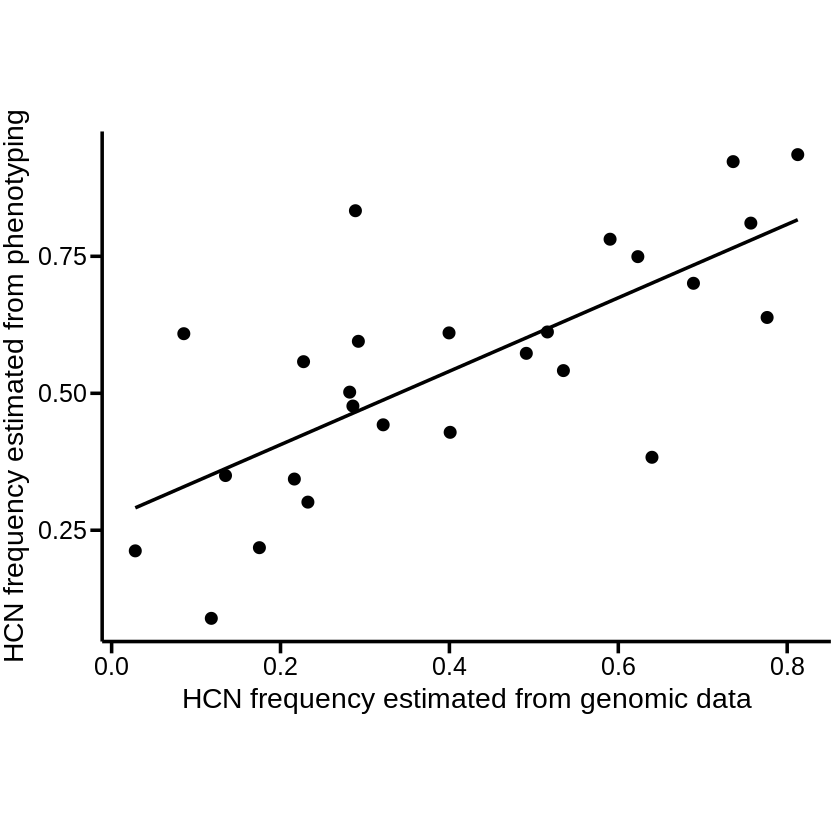

In [85]:
df_hcn_freqs <- left_join(all_freqs_wholeCity, hcnFreq_fromPhenotype, by = 'city') 
hcnFreq_corPlot <- df_hcn_freqs %>% 
    ggplot(., aes(x = hcnFreq_phen, y = hcn_est)) +
        geom_point(size = 3, color = 'black') +
        geom_smooth(method = 'lm', se = FALSE, color = 'black') +
        xlab('HCN frequency estimated from genomic data') +
        ylab('HCN frequency estimated from phenotyping') +
        ng1
hcnFreq_corPlot

print(cor.test(df_hcn_freqs$hcn_est, df_hcn_freqs$hcnFreq_phen))

## Estimate Fst at Ac and Li

- Load in Allele frequency estimates for both loci
- Estimate Hudson's Fst
- Return a single dataframe with Fst estimates for both loci and for all cities

In [119]:
qc_data_path <- '../../../../dnaSeqQC/results/qc/multiqc/multiqc_data/multiqc_qualimap_bamqc_genome_results_qualimap_bamqc.txt'
qc_data <- suppressMessages(read_delim(qc_data_path, delim = '\t')) %>% 
    mutate(sample = str_extract(Sample, '(?<=\\|\\s)\\w+(?=$)'))
highCovSamples <- qc_data %>% 
    filter(mean_coverage >= 0.5)

In [127]:
# Estimate urban and rural allele frequencies from genotype likelihoods
# Use only samples with coverage greater than 0.5X
ac_gls_highCov_Only <- ac_gls %>% filter(sample %in% highCovSamples$sample)
li_gls_highCov_Only <- li_gls %>% filter(sample %in% highCovSamples$sample)

ac_freq <- estimate_p(ac_gls_highCov_Only, by_site = TRUE) %>% mutate(locus = 'ac')
li_freq <- estimate_p(li_gls_highCov_Only, by_site = TRUE) %>% mutate(locus = 'li')

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


In [128]:
# Combine Ac and Li allele frequencies
all_freqs <- bind_rows(ac_freq, li_freq) %>% 
    arrange(city)
head(all_freqs)

city,n_r,n_u,p_r,p_u,fst,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,locus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Albuquerque,76,76,0.2414434,0.3199872,0.002029587,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,ac
Albuquerque,76,76,0.7627316,0.5204939,0.108207319,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,li
Antwerp,52,74,0.2774544,0.2883605,-0.016320770,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,ac
Antwerp,52,74,0.8289161,0.8867502,-0.003304623,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,li
Armidale,72,46,0.1968192,0.2233507,-0.016184653,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,ac
Armidale,72,46,0.4135496,0.5153343,0.002773150,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,li


`geom_smooth()` using formula 'y ~ x'



	Pearson's product-moment correlation

data:  freqChange_UR$ac_change and freqChange_UR$li_change
t = 1.3371, df = 24, p-value = 0.1937
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1381465  0.5904300
sample estimates:
      cor 
0.2632946 



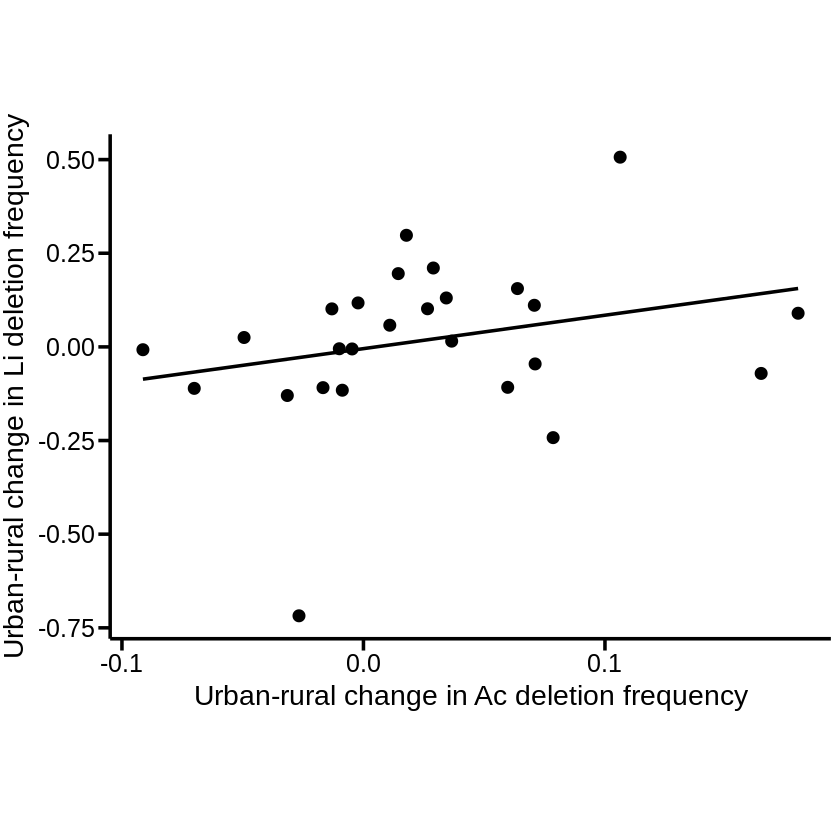

In [126]:
freqChange_UR <- all_freqs %>% 
    dplyr::select(city, starts_with('p_'), locus) %>% 
    pivot_wider(names_from = locus, values_from = starts_with('p_')) %>% 
    mutate(ac_change = p_u_ac - p_r_ac,
           li_change = p_u_li - p_r_li)

freqChange_UR_plot <- freqChange_UR %>% 
    ggplot(., aes(x = ac_change, y = li_change)) +
        geom_point(size = 3, color = 'black') +
        geom_smooth(method = 'lm', se = FALSE, color = 'black') +
        xlab('Urban-rural change in Ac deletion frequency') +
        ylab('Urban-rural change in Li deletion frequency') +
        ng1
freqChange_UR_plot
print(cor.test(freqChange_UR$ac_change, freqChange_UR$li_change, method = 'pearson'))

## Fst outlier analysis

- Compare Fst at Ac and Li loci to distribution of Fst values along same chromosomes

In [129]:
# Load per-site Fst values along chromosomes with Ac and Li
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    locus <- str_split(dirname(path), pattern = '/', simplify = TRUE)[2]
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>%
    
    # Cap numerators at 0 if negative
    # https://github.com/ANGSD/angsd/issues/309 # Does not affect overall pattern 
    mutate(num = ifelse(num < 0, 0, num),
           fst = num / denom) %>%
    mutate(city = city,
           locus = locus)
    
    return(df)
}

In [130]:
inpath <- '../../../results/angsd/summary_stats/fst/fst1/'
obs_fst_df <- list.files(inpath, pattern = '.*_(ac|li)_4fold_r_u_fst1_readable.fst', recursive = TRUE)  %>% 
    map_dfr(., load_obs_fst)
head(obs_fst_df)

chrom,pos,num,denom,fst,city,locus
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CM019103.1,16295,0.031660,0.480412,0.0659017676,Albuquerque,ac
CM019103.1,16460,0.000107,0.236729,0.0004519936,Albuquerque,ac
CM019103.1,16535,0.001080,0.332435,0.0032487554,Albuquerque,ac
CM019103.1,16658,0.001752,0.466036,0.0037593662,Albuquerque,ac
CM019103.1,16661,0.000000,0.252031,0.0000000000,Albuquerque,ac
CM019103.1,16799,0.000000,0.152620,0.0000000000,Albuquerque,ac


In [131]:
get_quantile <- function(df, probs = c(0.975)){
    
    city <- df %>% pull(city) %>% unique()
    locus <- df %>% pull(locus) %>% unique()
    fst <- df %>% filter(!(is.na(fst))) %>% pull(fst)
    
    quant <- quantile(fst, probs = probs)
    df_out <- data.frame(city = city, locus = locus, quant = quant)
    return(df_out)
}

In [132]:
neutral_fst_quantile_df <- obs_fst_df %>% 
    group_split(city, locus) %>% 
    map_dfr(., get_quantile)

In [136]:
all_stats_df <- left_join(all_freqs, neutral_fst_quantile_df, by = c('city', 'locus')) %>% 
    mutate(fst = ifelse(fst < 0, 0, fst),
           is_outlier = ifelse(fst > quant, 1, 0)) %>% 
    dplyr::select(-starts_with('n_'), -starts_with('p_'), -continent) %>% 
    mutate(sig = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No'))

In [148]:
all_stats_df %>% 
    dplyr::select(city, fst, betaLog_Dist, pvalLog_Dist, locus, is_outlier, sig)

city,fst,betaLog_Dist,pvalLog_Dist,locus,is_outlier,sig
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Albuquerque,0.002029587,-0.839,0.004,ac,0,Yes
Albuquerque,0.108207319,-0.839,0.004,li,1,Yes
Antwerp,0.000000000,2.150,0.000,ac,0,Yes
Antwerp,0.000000000,2.150,0.000,li,0,Yes
Armidale,0.000000000,1.487,0.000,ac,0,Yes
Armidale,0.002773150,1.487,0.000,li,0,Yes
Athens,0.000000000,1.565,0.000,ac,0,Yes
Athens,0.077163389,1.565,0.000,li,1,Yes
Bogota,0.038595096,0.839,0.014,ac,1,Yes


## Models

### Correlation between Fst and strength of cline

In [29]:
all_freqs %>% 
    group_by(locus) %>% 
    do(broom::tidy(lm(betaLog_Dist ~ fst, data = .)))

locus,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ac,(Intercept),0.7853182,0.2807320,2.7973941,0.00998945
ac,fst,-8.4690630,5.9429432,-1.4250621,0.16701507
li,(Intercept),0.5908219,0.3537248,1.6702869,0.10785504
li,fst,3.8146436,7.1615159,0.5326587,0.59916757


`geom_smooth()` using formula 'y ~ x'


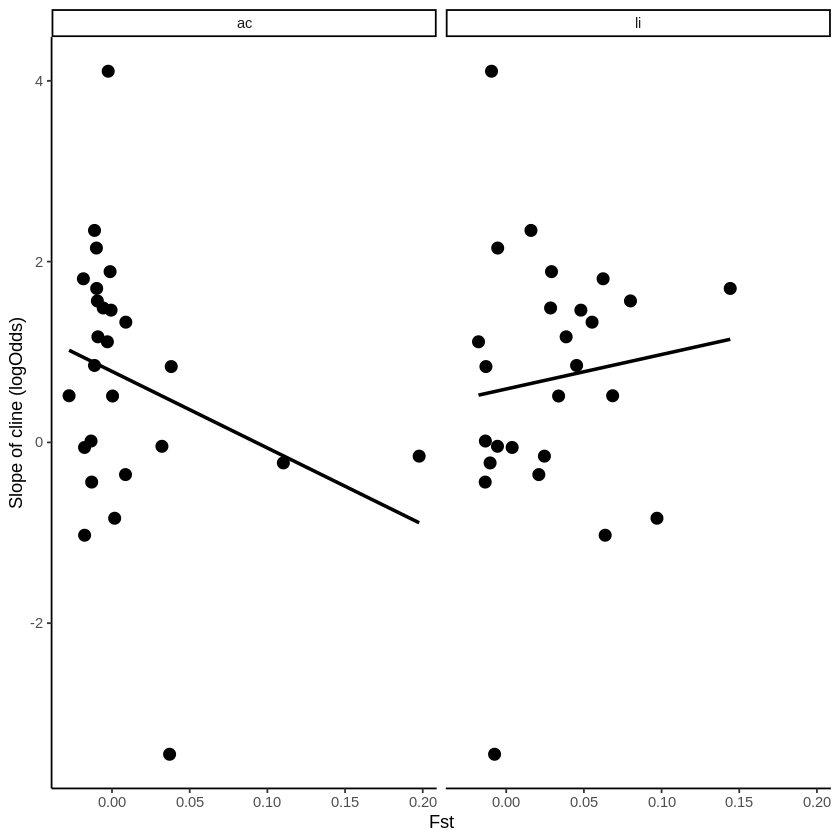

In [30]:
all_freqs %>% 
    group_by(locus) %>% 
    ggplot(., aes(x = fst, y = betaLog_Dist)) +
    geom_point(size = 3, color = 'black') +
    facet_wrap(~locus) +
    geom_smooth(method = 'lm', se = FALSE, color = 'black') +
    xlab('Fst') + ylab('Slope of cline (logOdds)') +
    theme_classic()

## Fst by sig cline

- Does Fst at HCN loci differ between cities with and without clines?


In [142]:
fst_by_cline <- lm(fst ~ sig*locus, data = all_stats_df)
summary(fst_by_cline)


Call:
lm(formula = fst ~ sig * locus, data = all_stats_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09877 -0.01655 -0.00243  0.00000  0.53173 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)    5.774e-18  3.494e-02   0.000    1.000
sigYes         2.428e-03  4.321e-02   0.056    0.955
locusli        1.486e-02  4.941e-02   0.301    0.765
sigYes:locusli 8.149e-02  6.111e-02   1.333    0.189

Residual standard error: 0.1048 on 48 degrees of freedom
Multiple R-squared:  0.1618,	Adjusted R-squared:  0.1095 
F-statistic: 3.089 on 3 and 48 DF,  p-value: 0.03575


### Chi-squared test

- Do loci show expected patterns of divergence based on whether they have clines?

In [162]:
all_stats_df_wide <- all_stats_df %>% 
    pivot_wider(names_from = 'locus', values_from = c('is_outlier', 'quant', 'fst')) %>% 
    mutate(one_outlier = ifelse(is_outlier_ac == 1 | is_outlier_li == 1, 'Yes', 'No')) %>% 
    group_by(sig, one_outlier)
all_stats_df_wide %>% 
    dplyr::select(city, sig, one_outlier)

city,sig,one_outlier
<chr>,<chr>,<chr>
Albuquerque,Yes,Yes
Antwerp,Yes,No
Armidale,Yes,No
Athens,Yes,Yes
Bogota,Yes,Yes
Buenos_Aires,No,No
Calgary,Yes,No
Canberra,No,No
Cape_Town,No,No


In [163]:
chisq_table <- table(all_stats_df_wide$sig, all_stats_df_wide$one_outlier)
chisq.test(chisq_table)

Warning message in chisq.test(chisq_table):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  chisq_table
X-squared = 0.66381, df = 1, p-value = 0.4152


In [164]:
chisq_table

     
      No Yes
  No   7   2
  Yes  9   8